In [24]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
# Read the CSV file
data = pd.read_csv('./data/Fraud_Data.csv')

In [3]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64


In [4]:
# Convert timestamp columns
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])

In [5]:
# Remove duplicates
data.drop_duplicates(inplace=True)

In [6]:
# Validate IP addresses
def validate_ip(ip):
    parts = str(int(ip)).split('.')
    if len(parts) != 4:
        return False
    for part in parts:
        if not part.isdigit() or int(part) < 0 or int(part) > 255:
            return False
    return True

data['valid_ip'] = data['ip_address'].apply(validate_ip)

In [7]:
# Handle outliers - purchase_value
purchase_value_mean = data['purchase_value'].mean()
purchase_value_std = data['purchase_value'].std()
outlier_threshold = purchase_value_mean + 3 * purchase_value_std

In [8]:
data = data[data['purchase_value'] <= outlier_threshold]


In [9]:
# Handle outliers - age
age_mean = data['age'].mean()
age_std = data['age'].std()
outlier_threshold = age_mean + 3 * age_std

In [10]:
data = data[data['age'] <= outlier_threshold]

In [11]:

# Standardize categorical variables - source
data['source'] = data['source'].str.lower()

# Standardize categorical variables - browser
data['browser'] = data['browser'].str.lower()

In [12]:
# Feature engineering
data['signup_purchase_duration'] = data['purchase_time'] - data['signup_time']
data['age_bracket'] = pd.cut(data['age'], bins=[0, 18, 30, 40, 50, 120], labels=['<18', '18-30', '31-40', '41-50', '50+'])
data['device_id_info'] = data['device_id'].str[:3]

Feature engineering and create time-based features

In [16]:
# Feature Engineering - Transaction frequency and velocity
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])

In [18]:
# Transaction frequency
data['transaction_frequency'] = data.groupby('user_id')['user_id'].transform('count')

In [19]:
# Transaction velocity
data['transaction_velocity'] = data['purchase_value'] / ((data['purchase_time'] - data['signup_time']).dt.total_seconds())


In [20]:
# Time-Based features
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])

In [21]:
# Hour of day
data['hour_of_day'] = data['purchase_time'].dt.hour

# Day of week
data['day_of_week'] = data['purchase_time'].dt.dayofweek

 Normalization and Scaling

In [26]:
# Normalization and Scaling
scaler = MinMaxScaler()
data[['purchase_value', 'age', 'transaction_frequency', 'transaction_velocity']] = scaler.fit_transform(data[['purchase_value', 'age', 'transaction_frequency', 'transaction_velocity']])


In [30]:
# Encode Categorical Features
encoder = OneHotEncoder(sparse=False)
categorical_features = ['source', 'browser', 'sex']
encoded_features = encoder.fit_transform(data[categorical_features])

c:\Users\huawei\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [33]:
# Retrieve feature names from categories
categories = encoder.categories_
feature_names = [f"{feature}_{category}" for feature, cats in zip(categorical_features, categories) for category in cats]


In [34]:
# Create a new DataFrame with encoded categorical features
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)


In [35]:
# Concatenate the encoded DataFrame with the original DataFrame
df_encoded = pd.concat([data, encoded_df], axis=1)

In [37]:
# Drop the original categorical columns
df_encoded.drop(categorical_features, axis=1, inplace=True)

In [39]:
# Save the modified data as CSV
data.to_csv('Cleaned FraudData.csv', index=False)

print("Cleaned data saved as 'Cleaned FraudData.csv'")

Cleaned data saved as 'Cleaned FraudData.csv'


EDA

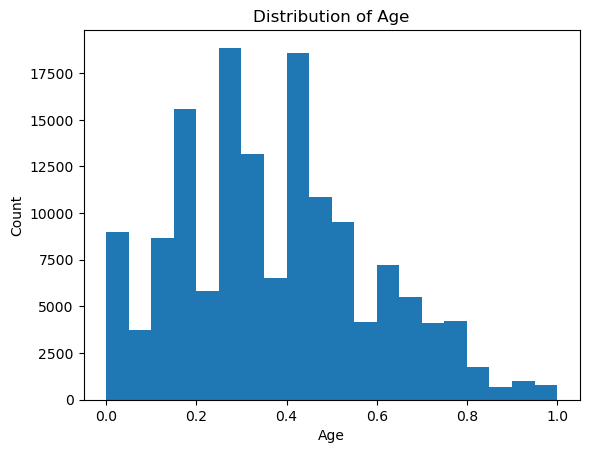

In [40]:
import matplotlib.pyplot as plt

# Plot the histogram of a numerical feature
plt.hist(data['age'], bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.show()

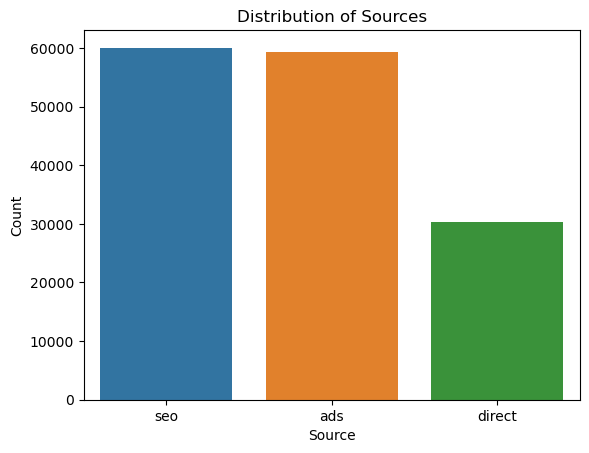

In [41]:
import seaborn as sns

# Plot a bar plot of a categorical feature
sns.countplot(x='source', data=data)
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Distribution of Sources')
plt.show()

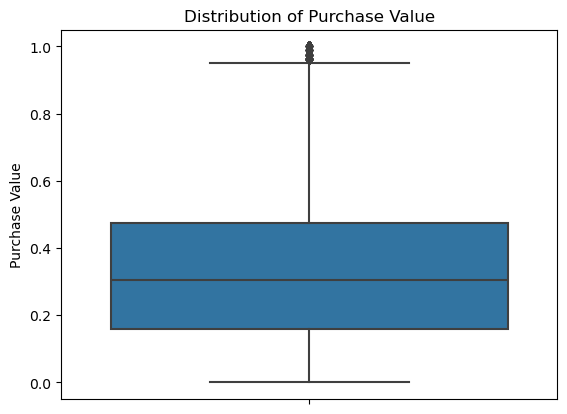

In [42]:
# Plot a box plot of a numerical feature
sns.boxplot(y='purchase_value', data=data)
plt.ylabel('Purchase Value')
plt.title('Distribution of Purchase Value')
plt.show()

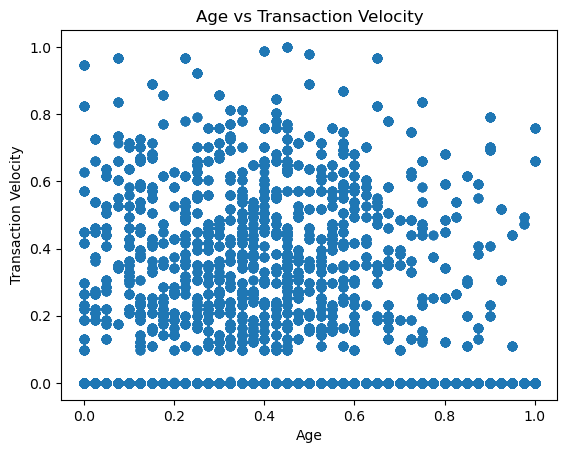

In [43]:
# Plot a scatter plot of two numerical features
plt.scatter(data['age'], data['transaction_velocity'])
plt.xlabel('Age')
plt.ylabel('Transaction Velocity')
plt.title('Age vs Transaction Velocity')
plt.show()

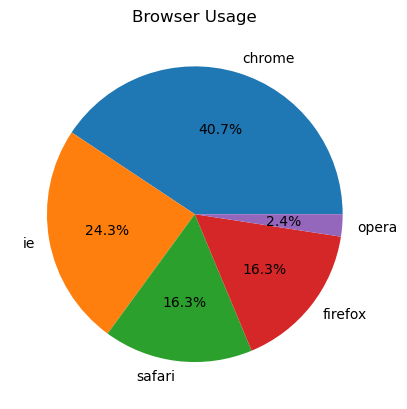

In [44]:
# Plot a pie chart of a categorical feature
category_counts = data['browser'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Browser Usage')
plt.show()

c:\Users\huawei\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


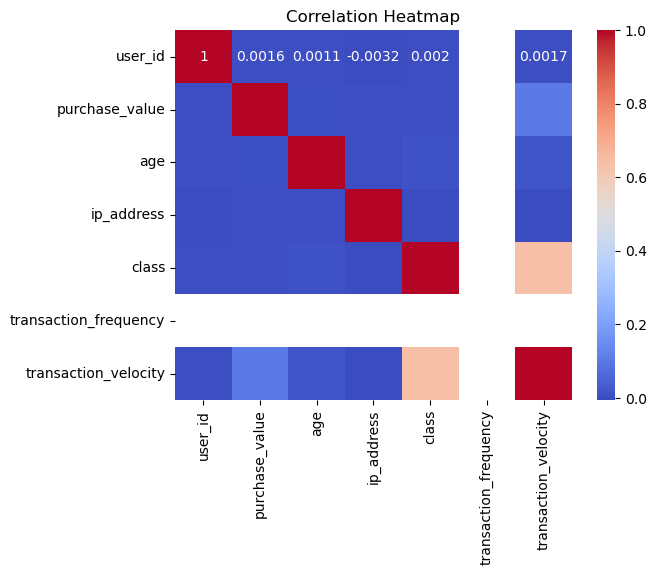

In [46]:
# Select only numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr_matrix = numerical_columns.corr()

# Plot the correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()